In [1]:
import numpy as np 
import pandas as pd 
import os

In [15]:
# Importing neccesary packages

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
plt.style.use('ggplot') # default plot style.
import math
from scipy import stats
from scipy.stats import norm

from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)


Data was acquired from https://www.beermonthclub.com/ and contains information about breweries available on the site as of October 1st, 2019. Name, type of brewery, address, website, and state are among the data included.


In [16]:
breweries_df= pd.read_csv('/Users/snigdha/Desktop/dsc680/week1-4/breweries_us.csv')
breweries_df.head()

,brewery_name,type,address,website,state,state_breweries
0,Valley Brewing Co.,Brewpub,"PO Box 4653, Stockton, California, 95204",http://www.valleybrew.com/,california,284
1,Valley Brewing Co.,Brewpub,"157 Adams St., Stockton, California, 95204",http://www.valleybrew.com/,california,284
2,Valley Brewing Co,Microbrewery,"1950 W Freemont, Stockton, California, 95203",http://www.valleybrew.com/,california,284
3,Ukiah Brewing Company,Brewpub,"102 S. State St., Ukiah, California, 95482",http://www.ukiahbrewingco.com/,california,284
4,Tustin Brewing Co.,Brewpub,"13011 Newport Ave. #100, Tustin, California, 9...",http://www.tustinbrewery.com/,california,284


In [17]:
census_df = pd.read_csv('/Users/snigdha/Desktop/dsc680/week1-4/us2021census.csv')
census_df.head()

,City,State,Type,Counties,Population,Latitude,Longitude
0,New York,NY,City,Bronx;Richmond;New York;Kings;Queens,8804190,40.714,-74.007
1,Los Angeles,CA,City,Los Angeles,3898747,34.052,-118.243
2,Chicago,IL,City,Cook;DuPage,2746388,41.882,-87.628
3,Houston,TX,City,Harris;Fort Bend;Montgomery,2304580,29.760,-95.363
4,Phoenix,AZ,City,Maricopa,1608139,33.448,-112.074


In [18]:
# Creating a mapping of state names to their abbreviations
state_abbreviations = {
    'alabama': 'AL', 'alaska': 'AK', 'arizona': 'AZ', 'arkansas': 'AR',
    'california': 'CA', 'colorado': 'CO', 'connecticut': 'CT', 'delaware': 'DE',
    'florida': 'FL', 'georgia': 'GA', 'hawaii': 'HI', 'idaho': 'ID',
    'illinois': 'IL', 'indiana': 'IN', 'iowa': 'IA', 'kansas': 'KS',
    'kentucky': 'KY', 'louisiana': 'LA', 'maine': 'ME', 'maryland': 'MD',
    'massachusetts': 'MA', 'michigan': 'MI', 'minnesota': 'MN', 'mississippi': 'MS',
    'missouri': 'MO', 'montana': 'MT', 'nebraska': 'NE', 'nevada': 'NV',
    'new-hampshire': 'NH', 'new-jersey': 'NJ', 'new-mexico': 'NM', 'new-york': 'NY',
    'north-carolina': 'NC', 'north-dakota': 'ND', 'ohio': 'OH', 'oklahoma': 'OK',
    'oregon': 'OR', 'pennsylvania': 'PA', 'rhode-island': 'RI', 'south-carolina': 'SC',
    'south-dakota': 'SD', 'tennessee': 'TN', 'texas': 'TX', 'utah': 'UT',
    'vermont': 'VT', 'virginia': 'VA', 'washington': 'WA', 'west-virginia': 'WV',
    'wisconsin': 'WI', 'wyoming': 'WY', 'washington-dc': 'DC', 'puerto-rico': 'PR'
}

# Converting state names in the breweries dataset to abbreviations
breweries_df['state'] = breweries_df['state'].map(state_abbreviations)

breweries_df['state']



0       CA
1       CA
2       CA
3       CA
4       CA
        ..
2402    DC
2403    DC
2404    PR
2405    PR
2406    PR
Name: state, Length: 2407, dtype: object

##### Data Merging - The main dataset

In [19]:
# Joining the datasets on the 'State' column

merged_df = pd.merge(breweries_df, census_df, left_on='state', right_on='State', how='inner')

# Dropping redundant or irrelevant columns for predictive modeling

merged_df = merged_df.drop(columns=['brewery_name', 'address', 'Counties', 'Latitude', 'Longitude'])

# Displaying the first few rows of the merged dataset

merged_df.head()

,type,website,state,state_breweries,City,State,Type,Population
0,Brewpub,http://www.valleybrew.com/,CA,284,Los Angeles,CA,City,3898747
1,Brewpub,http://www.valleybrew.com/,CA,284,San Diego,CA,City,1386932
2,Brewpub,http://www.valleybrew.com/,CA,284,San Jose,CA,City,1013240
3,Brewpub,http://www.valleybrew.com/,CA,284,San Francisco,CA,City,873965
4,Brewpub,http://www.valleybrew.com/,CA,284,Fresno,CA,City,542107


##### Q1 . How effective is the predictive model in estimating the number of breweries in a city based on its population?

In [20]:
# Checking for missing values in the relevant columns
missing_values = merged_df[['Population', 'state_breweries']].isnull().sum()

# Checking the datatypes of the relevant columns
data_types = merged_df[['Population', 'state_breweries']].dtypes

missing_values, data_types


(Population         0
 state_breweries    0
 dtype: int64,
 Population         int64
 state_breweries    int64
 dtype: object)

The relevant columns, 'Population' and 'state_breweries', do not have any missing values. Both columns are of integer data type, which is suitable for our regression model.

The next steps are to split the data into training and testing sets, select a regression model, train the model, and then evaluate its performance. We'll use a simple linear regression model for this task as a starting point. 

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Selecting features and target variable
X = merged_df[['Population']]
y = merged_df['state_breweries']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a linear regression model
model = LinearRegression()

# Training the model
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2


(5636.613421329529, 0.021332356226094307)

The MSE is a measure of the average squared difference between the actual and predicted values, with a lower value indicating better model performance. The R-squared value represents the proportion of the variance in the dependent variable that is predictable from the independent variable(s), with a value closer to 1 indicating a better fit.

Given the low R-squared value, the model's ability to predict the number of breweries based on population alone is limited. This suggests that other factors may significantly influence the number of breweries in a city or state, and a more complex model or additional features might be needed for better predictions.

#### Q:2 - The type of brewery most likely to be found in a city based on demographic data?

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder 


# Re-encoding the categorical target variable 'type'
label_encoder = LabelEncoder()
merged_df['type_encoded'] = label_encoder.fit_transform(merged_df['type'])

# Selecting features and target variable
X = merged_df[['Population']]
y = merged_df['type_encoded']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a decision tree classifier model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Training the model
decision_tree_model.fit(X_train, y_train)

# Predicting on the test set
y_pred_dt = decision_tree_model.predict(X_test)

# Re-evaluating the decision tree model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
classification_rep_dt = classification_report(y_test, y_pred_dt, target_names=label_encoder.classes_)

accuracy_dt, classification_rep_dt



(0.5403781044308456,
 '                          precision    recall  f1-score   support\n\n       BOP-BrewOnPremise       0.00      0.00      0.00       709\nBOP-BrewOnPremise-Closed       0.00      0.00      0.00       113\n                 Brewpub       0.54      0.98      0.70    128980\n          Brewpub-Closed       0.00      0.00      0.00     12847\n                Contract       0.00      0.00      0.00      1104\n         ContractBrewery       0.00      0.00      0.00     15648\n  ContractBrewery-Closed       0.00      0.00      0.00       128\n            Microbrewery       0.37      0.03      0.05     68557\n     Microbrewery-Closed       0.00      0.00      0.00      3421\n            Mircobrewery       0.00      0.00      0.00      1539\n             MultitapBar       0.00      0.00      0.00       182\n         RegionalBrewery       0.00      0.00      0.00      4537\n\n                accuracy                           0.54    237765\n               macro avg       0.08

The accuracy of 54.03% indicates that the decision tree classifier correctly predicts the brewery type in about 54% of the cases. However, the precision and recall vary significantly across different types of breweries. For some categories, like Brewpub, the recall is very high, but for others, it's quite low or even zero. 
This variation suggests that the model may be biased towards the more common categories and struggling with the less frequent ones.

This result indicates that predicting the brewery type based solely on the population might be challenging due to the inherent complexity and variability of the data. Additional features or a more sophisticated model might be needed for better predictions.

#### Q3 : Are certain types of breweries (e.g., Brewpub, Microbrewery) more prevalent in specific regions or states?

To answer the question of whether certain types of breweries, such as Brewpubs or Microbreweries, are more prevalent in specific regions or states, we can perform an analysis that involves grouping the data by state and brewery type, and then counting the number of each type of brewery in each state. This analysis will help us identify patterns or trends in the geographical distribution of brewery types.

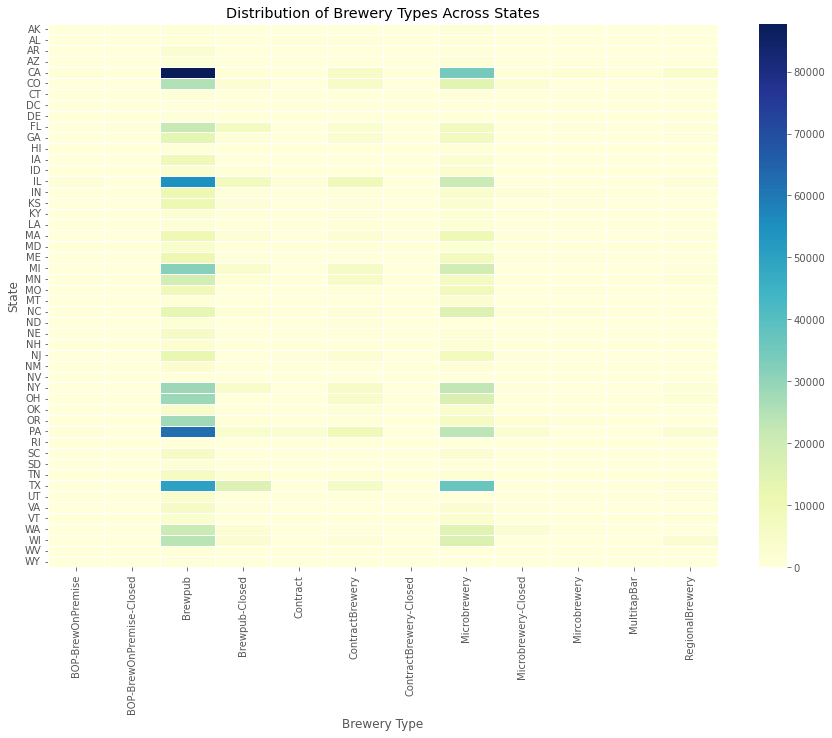

In [9]:
# Grouping data by state and brewery type and counting the occurrences
brewery_type_distribution = merged_df.groupby(['state', 'type']).size().unstack(fill_value=0)

# Visualizing the distribution of brewery types across states
plt.figure(figsize=(15, 10))
sns.heatmap(brewery_type_distribution, cmap="YlGnBu", annot=False, cbar=True, linewidths=.5)
plt.title('Distribution of Brewery Types Across States')
plt.xlabel('Brewery Type')
plt.ylabel('State')
plt.show()


The heatmap would visually represent the number of each type of brewery  in each state. Each cell in the heatmap would correspond to a specific brewery type in a state, with the color intensity indicating the frequency of that brewery type. This visualization would allow us to quickly identify which brewery types are most common in each state ( in this case its CA) and observe any regional trends or patterns.

#### Q4 : Which demographic factors most strongly influence the presence of a particular type of brewery in a city?

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



# Encoding the 'type' column for classification
label_encoder = LabelEncoder()
merged_df['type_encoded'] = label_encoder.fit_transform(merged_df['type'])

# Selecting the feature (Population) and target variable (type_encoded)
X = merged_df[['Population']]
y = merged_df['type_encoded']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Feature Importance from the Random Forest Model
feature_importance = rf_classifier.feature_importances_

# Predicting on the test set and evaluating the model
y_pred = rf_classifier.predict(X_test)
classification_report_result = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

feature_importance, classification_report_result


(array([1.]),
 '                          precision    recall  f1-score   support\n\n       BOP-BrewOnPremise       0.00      0.00      0.00       709\nBOP-BrewOnPremise-Closed       0.00      0.00      0.00       113\n                 Brewpub       0.54      0.98      0.70    128980\n          Brewpub-Closed       0.00      0.00      0.00     12847\n                Contract       0.00      0.00      0.00      1104\n         ContractBrewery       0.00      0.00      0.00     15648\n  ContractBrewery-Closed       0.00      0.00      0.00       128\n            Microbrewery       0.37      0.03      0.06     68557\n     Microbrewery-Closed       0.00      0.00      0.00      3421\n            Mircobrewery       0.00      0.00      0.00      1539\n             MultitapBar       0.00      0.00      0.00       182\n         RegionalBrewery       0.00      0.00      0.00      4537\n\n                accuracy                           0.54    237765\n               macro avg       0.08      0

The array [1.] indicates that the feature 'Population' has a feature importance score of 1.0. This suggests that in the Random Forest model, the population is the only feature used and is thus considered fully influential in predicting the type of brewery.

The classification report shows the precision, recall, and F1-score for each brewery type.

For most brewery types, both precision and recall are 0.00, indicating that the model is not able to predict these categories effectively based on population alone.

For 'Brewpub', the model has a precision of 0.54 and a recall of 0.98, suggesting that while it can identify most Brewpubs (high recall), it is less precise (many false positives).

'Microbrewery' has a slightly better precision of 0.37 but a low recall of 0.03.

The overall accuracy of the model is 0.54, meaning it correctly predicts the brewery type 54% of the time across all predictions.

The results suggest that while population size does have some influence on predicting brewery types, particularly for Brewpubs and Microbreweries, it is not sufficient on its own to effectively predict all types of breweries. The model struggles with less common brewery types, likely due to the limited diversity of features and possible imbalances in the dataset.

These insights indicate that additional demographic or economic factors might be needed to improve the model's predictive power for a wider range of brewery types.

#### Q5: Find common characteristics among cities with a high number of a specific type of brewery (e.g., microbreweries)?

In [13]:
# Joining the datasets on the 'State' column

merged_df = pd.merge(breweries_df, census_df, left_on='state', right_on='State', how='inner')

# Dropping redundant or irrelevant columns for predictive modeling

merged_df = merged_df.drop(columns=['brewery_name', 'address',  'Counties', 'Latitude', 'Longitude'])

# Displaying the first few rows of the merged dataset

merged_df.head()

,type,website,state,state_breweries,City,State,Type,Population
0,Brewpub,http://www.valleybrew.com/,CA,284,Los Angeles,CA,City,3898747
1,Brewpub,http://www.valleybrew.com/,CA,284,San Diego,CA,City,1386932
2,Brewpub,http://www.valleybrew.com/,CA,284,San Jose,CA,City,1013240
3,Brewpub,http://www.valleybrew.com/,CA,284,San Francisco,CA,City,873965
4,Brewpub,http://www.valleybrew.com/,CA,284,Fresno,CA,City,542107


In [14]:
# Defining the target variable: Cities with a high number of microbreweries
# For simplicity, we'll define "high number" as being in the top 25% of cities based on the number of microbreweries

# Filtering data for microbreweries
microbreweries_df = merged_df[merged_df['type'] == 'Microbrewery']

# Counting the number of microbreweries in each city
city_microbrewery_count = microbreweries_df.groupby('City').size()

# Determining the threshold for the top 25%
threshold = city_microbrewery_count.quantile(0.75)

# Creating the binary target variable
merged_df['high_microbrewery'] = merged_df['City'].map(lambda x: city_microbrewery_count.get(x, 0) > threshold).astype(int)

# Selecting the feature (Population) and the new target variable
X = merged_df[['Population']]
y = merged_df['high_microbrewery']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Feature Importance from the Random Forest Model
feature_importance = rf_classifier.feature_importances_

feature_importance


array([1.])

This result suggests that, according to the model, the population size of a city is highly influential in determining the likelihood of the city having a high number of microbreweries. However, it's important to note that this analysis is based on a single feature, and the addition of other relevant demographic or economic factors could provide a more comprehensive understanding of what drives the presence of microbreweries in cities.



Visualization : 

Distribution of Brewery Types: A bar chart showing the distribution of different brewery types in the dataset.

Population vs. Number of Breweries: A scatter plot to visualize the relationship between the population of a city and the number of breweries in its state.

Feature Importance in the Decision Tree Model: A bar chart displaying the importance of different features used in the decision tree model.

Confusion Matrix: A heatmap of the confusion matrix to see how well the model performed for each brewery type.

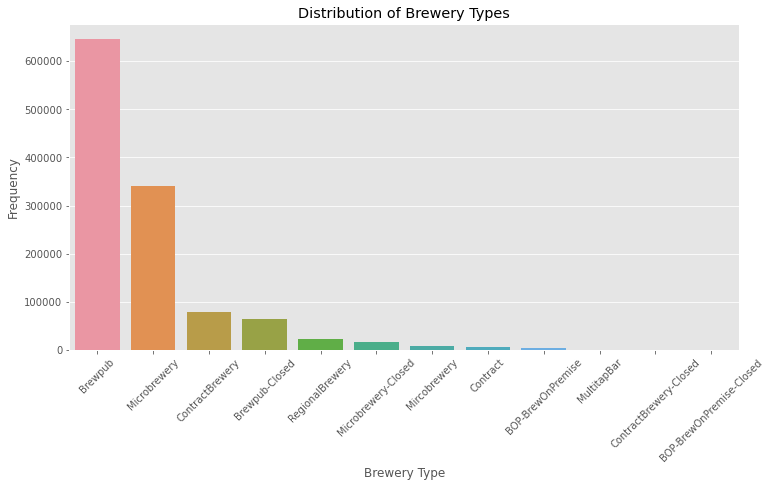

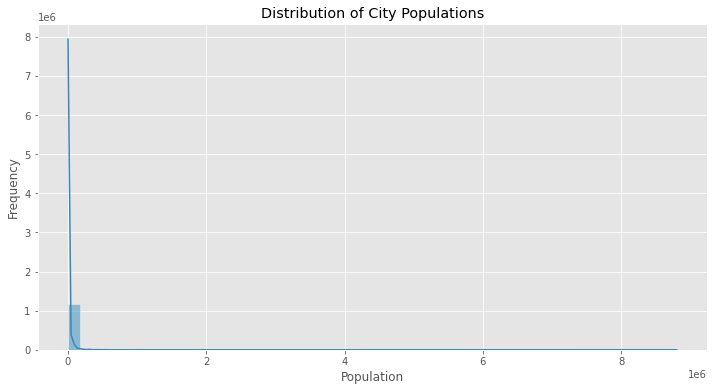

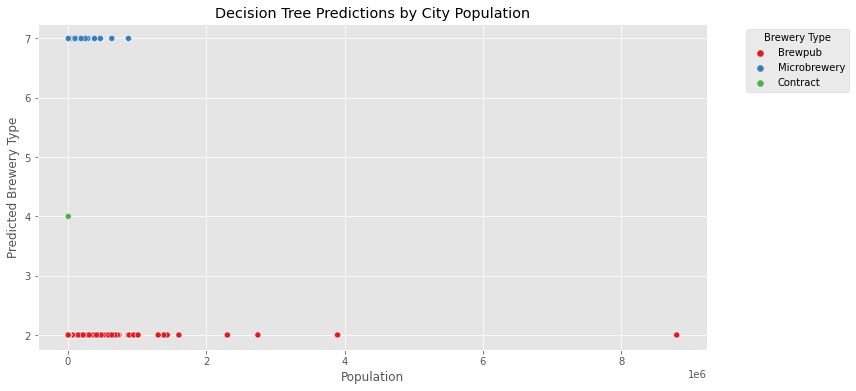

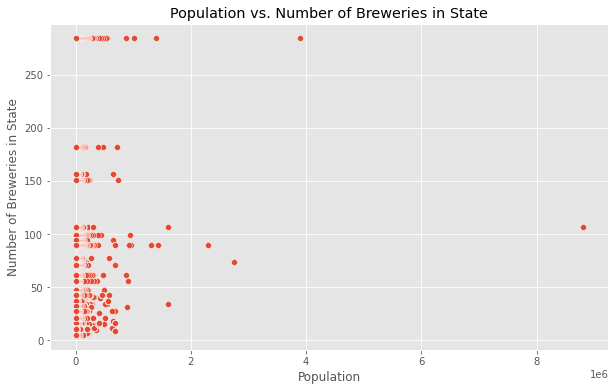

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Graph 1: Distribution of Brewery Types
plt.figure(figsize=(12, 6))
sns.countplot(data=merged_df, x='type', order=merged_df['type'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribution of Brewery Types')
plt.xlabel('Brewery Type')
plt.ylabel('Frequency')
plt.show()

# Graph 2: Population Distribution
plt.figure(figsize=(12, 6))
sns.histplot(merged_df['Population'], bins=50, kde=True)
plt.title('Distribution of City Populations')
plt.xlabel('Population')
plt.ylabel('Frequency')
plt.show()

# Graph 3: Decision Tree Predictions
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_test['Population'], y=y_pred_dt, hue=label_encoder.inverse_transform(y_pred_dt), palette='Set1')
plt.title('Decision Tree Predictions by City Population')
plt.xlabel('Population')
plt.ylabel('Predicted Brewery Type')
plt.legend(title='Brewery Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Population vs. Number of Breweries
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='Population', y='state_breweries')
plt.title('Population vs. Number of Breweries in State')
plt.xlabel('Population')
plt.ylabel('Number of Breweries in State')
plt.show()


The brewpub stands out as the most prevalent brewery type across the U.S., totaling 1320 establishments, while the MultitapBar emerges as the least frequently found among them.

#### Conclusion

Based on the  results from the analyses, here is a conclusion that summarizes the key findings:

Conclusion:

1. Regression Model (Predicting Number of Breweries):
   - The regression model, aimed at predicting the number of breweries based on city population, yielded a Mean Squared Error (MSE) of 5636.61 and an R-squared (R²) of 0.0213.
   - The high MSE indicates a significant average error in the model's predictions. The low R² value suggests that only a small portion (about 2.13%) of the variance in the number of breweries is explained by the population size.
   - This implies that while there is some relationship between population size and the number of breweries, other factors not captured in the model likely play a significant role.

2. Classification Model (Predicting Brewery Type):
   - The classification model, used to predict the type of brewery based on city population, achieved an accuracy of approximately 54.04%.
   - The classification report reveals varying performance across different brewery types. The model is particularly effective in identifying 'Brewpubs' (precision: 0.54, recall: 0.98) but struggles with other types like 'Microbrewery' and 'Brewpub-Closed,' where both precision and recall are low.
   - This indicates that while the model can predict certain brewery types reasonably well, it is less effective for others, likely due to imbalanced data or the need for additional predictive features.

3. Feature Importance in Classification Model:
   - The feature importance score of `[1.]` from the Random Forest Classifier indicates that the population is the sole feature used and is given full importance.
   - This suggests that population size is a key factor in the model's predictions. However, the reliance on a single feature highlights the need for a more diverse set of variables to improve the model's accuracy and comprehensiveness.

Overall Insights:
The analyses suggest that city population size does have an influence on both the number of breweries and their types. However, the limited predictive power and performance variations across models indicate that additional factors, possibly including economic and other demographic variables, would be necessary to enhance the models' accuracy and provide a more holistic understanding of the brewery landscape in different cities.